In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pathlib
import numpy as np

In [2]:
tf.test.is_gpu_available()

True

In [3]:
print('Version: {}'.format(tf.__version__))

Version: 2.0.0-beta1


In [4]:
import csv
id_dict ={}
with open('train.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for k,v in reader:
        id_dict[k] = int(v)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
main_path = pathlib.Path(r"C:\Users\Toby-PC\Documents\code\blindness_kaggle")
train_path = main_path / 'train_cropped'
test_path = main_path / 'test_cropped'

In [7]:
import random
train_image_paths = [str(path) for path in list(train_path.glob('*.png'))]
random.shuffle(train_image_paths)
# test_image_paths = [str(path) for path in list(test_path.glob('*.png'))]


print('Number of training images:', len(train_image_paths))
# print('Number of testing images:', len(test_image_paths))

Number of training images: 3662


In [8]:
labels = [id_dict[path[-16:-4]] for path in train_image_paths]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_image_paths, labels, test_size=0.2)

In [10]:
image_count = len(X_train)
image_count

2929

In [11]:
target_im_size = [384, 384]

def preprocess_image(image, random=False):
    image = tf.image.decode_png(image, channels=3)
    if random:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_hue(image, 0.2)
        image = tf.image.rot90(image, tf.random_uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        image = tf.image.random_shift(image, 0.2, 0.2)
        image = tf.image.random_zoom(image, (0.6, 1))
    else:
        pass
    
#     image = tf.image.rgb_to_grayscale(image)
    image = tf.image.per_image_standardization(image)
    image = tf.image.central_crop(image, 0.8)
    image = tf.image.resize(image, target_im_size)
    image = tf.cast(image, tf.float32)
    image /= 255.0  
    return image


In [12]:
def load_and_preprocess_image(path, random=False):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [13]:
train_path_ds = tf.data.Dataset.from_tensor_slices(X_train)
test_path_ds = tf.data.Dataset.from_tensor_slices(X_test)

In [14]:
from functools import partial

train_image_ds = train_path_ds.map(partial(load_and_preprocess_image, random=True), num_parallel_calls=AUTOTUNE)
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

W0712 20:11:51.408938 14760 deprecation.py:323] From c:\users\toby-pc\documents\code\blindness_kaggle\my_env\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [15]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,8))
# for n, image in enumerate(train_image_ds.take(4)):
#     plt.subplot(2,2,n+1)
#     plt.imshow(image)
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

In [16]:
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y_train, tf.int64))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y_test, tf.int64))

In [17]:
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))

In [18]:
print(train_image_label_ds)

<ZipDataset shapes: ((384, 384, 3), ()), types: (tf.float32, tf.int64)>


In [19]:
# ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))

# # The tuples are unpacked into the positional arguments of the mapped function
# def load_and_preprocess_from_path_label(path, label):
#     return load_and_preprocess_image(path), label

# image_label_ds = ds.map(load_and_preprocess_from_path_label)
# image_label_ds

In [20]:
BATCH_SIZE = 64

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = train_image_label_ds.shuffle(buffer_size=image_count)
ds = ds.cache()

ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(1)
ds

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
testds = test_image_label_ds.shuffle(buffer_size=image_count)
testds = testds.cache()

testds = testds.repeat()
testds = testds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
testds = testds.prefetch(1)
testds

<PrefetchDataset shapes: ((None, 384, 384, 3), (None,)), types: (tf.float32, tf.int64)>

In [21]:
from tensorflow.keras import regularizers


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (7, 7), padding='valid', activation='relu', input_shape=(*target_im_size, 3))) # CNN Layer 1
model.add(tf.keras.layers.MaxPooling2D((5, 5))) # Pooling layer 1

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='valid', activation='relu')) # CNN Layer 1
model.add(tf.keras.layers.MaxPooling2D((4, 4))) # Pooling layer 1

# model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='valid', activation='relu')) # CNN Layer 1
# model.add(tf.keras.layers.MaxPooling2D((2, 2))) # Pooling layer 1

# model.add(tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='valid', depth_multiplier=1))

model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='valid', activation='relu')) # CNN Layer 1
model.add(tf.keras.layers.Flatten()) # Flattening layer

model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0))) # Fully-connected layer "on top"
model.add(tf.keras.layers.Dropout(rate=0.8))

# model.add(tf.keras.layers.Dense(64, activation='relu')) # Fully-connected layer "on top"
# model.add(tf.keras.layers.Dropout(rate=0.5))

model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0))) # Fully-connected layer "on top"
model.add(tf.keras.layers.Dropout(rate=0.8))

model.add(tf.keras.layers.Dense(5, activation='softmax')) # Softmax output from logits

W0712 20:11:51.820837 14760 nn_ops.py:4220] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0712 20:11:51.841780 14760 nn_ops.py:4220] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [22]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 378, 378, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 512)       590336    
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [24]:
steps_per_epoch=int(tf.math.ceil(len(X_train)/BATCH_SIZE).numpy())
steps_per_epoch

steps_per_test=int(tf.math.ceil(len(X_test)/BATCH_SIZE).numpy())

In [25]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

In [26]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [27]:
# %load_ext tensorboard
# %tensorboard --logdir=./my_logs --port=6006
# !tensorboard --logdir=./my_logs --port=6006


history = model.fit(ds, 
                    epochs=500, 
                    steps_per_epoch=steps_per_epoch, 
                    verbose=1,
                    validation_data=testds,
                    validation_steps=steps_per_test,
                    callbacks=[es, tensorboard_cb]
               )

Epoch 1/500


W0712 20:12:00.180484 14760 deprecation.py:323] From c:\users\toby-pc\documents\code\blindness_kaggle\my_env\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


46/46 [==============================] - 21s 465ms/step - loss: 1.7787 - accuracy: 0.3227 - val_loss: 1.3788 - val_accuracy: 0.5156
Epoch 2/500
46/46 [==============================] - 11s 231ms/step - loss: 1.3702 - accuracy: 0.4436 - val_loss: 1.0090 - val_accuracy: 0.5560
Epoch 3/500
46/46 [==============================] - 10s 227ms/step - loss: 1.2029 - accuracy: 0.5099 - val_loss: 0.9332 - val_accuracy: 0.7161
Epoch 4/500
46/46 [==============================] - 10s 225ms/step - loss: 1.1318 - accuracy: 0.5713 - val_loss: 0.9046 - val_accuracy: 0.6992
Epoch 5/500
46/46 [==============================] - 10s 223ms/step - loss: 1.0768 - accuracy: 0.6199 - val_loss: 0.8925 - val_accuracy: 0.7174
Epoch 6/500
46/46 [==============================] - 10s 212ms/step - loss: 1.0384 - accuracy: 0.6393 - val_loss: 0.8475 - val_accuracy: 0.7148
Epoch 7/500
46/46 [==============================] - 10s 215ms/step - loss: 1.0099 - accuracy: 0.6610 - val_loss: 0.8560 - val_accuracy: 0.7174
Epoc

In [28]:
model.evaluate(testds, steps=steps_per_test)

12/12 [==============================] - 3s 248ms/step - loss: 0.7536 - accuracy: 0.7331


[0.7536208033561707, 0.73307294]

In [29]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title(f'Epoch vs. {string}')

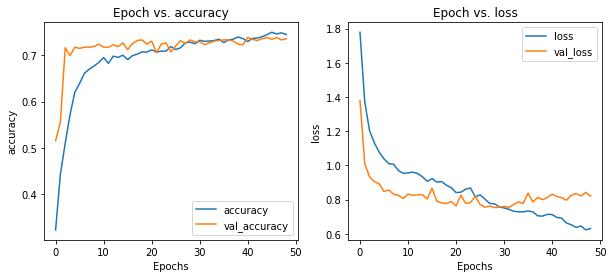

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')

plt.subplot(1,2,2)
plot_graphs(history, 'loss')

